Import Packages

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
from moviepy.editor import VideoFileClip 
from IPython.display import HTML 
%matplotlib inline

In [3]:
# Create a Class for some useful Enums
class Enum( tuple ): __getattr__ = tuple.index 

# Define Enum for ColorSpaces
ColorSpace = Enum( ['RGB', 'HSV', 'HSL'] ) 

# Select ColorSpace 
# !!!! Feel free to change this to RGB,HSV, or HSL!!!!! 
colorspace = ColorSpace.RGB 

# Debug Flag to plot intermediate color masks 
# Set plot_color_masks = True to plot the masks 
plot_color_masks = False 

# Hough Line parameters 
rho = 1 
theta = np.pi/180 

threshold = 1 
min_line_len = 5 
max_line_gap = 10 

# Gaussian Smoothing kernel size 
kernel_size = 5 

# Canny edge detector thresholds 
low_threshold = 50 
high_threshold = 150 

def find_images( img_dir ):
   """Find and return a list of various image file formats"""
   image_files = []
   for filename in os.listdir( img_dir ):
       if any( filename.endswith( f ) for f in ( '.jpg', '.jpeg','.gif', '.png' ) ):
           image_files.append( os.path.abspath( img_dir+'/'+filename ) )
   return sorted(image_files)

def plot_images( image_files ):
   """Plot all images in a neat fashion using subplot"""
   if not image_files:
       print( "No image files found in path = {}".format( image_files ) )
   else:
       num_images = len( image_files )
       plot_cols = 2
       plot_rows = math.ceil( num_images / 2 )
       # Set figure size 20x20 inches which works for displaying in jupyter notebook
       plt.figure( figsize = ( 20, 20 ), facecolor='white' )
       for i,img in enumerate( image_files ):
           image = mpimg.imread( img ) 
           _, filename = os.path.split( img )
           if len( image.shape ) == 2: 
               colortype = 'gray' 
           else: 
               colortype = None 
           plot_num = i+1
           ax = plt.subplot( plot_rows, plot_cols, plot_num ) 
           ax.set_title( filename, fontsize = 24 )
           plt.imshow( image, cmap=colortype )
           plt.xticks([]),plt.yticks([])
       plt.tight_layout()

def save_image( img, path, fname ): 
   """Saves an image to disk"""
   output_path = os.path.join( path, fname ) 
   if len( img.shape ) == 2: 
       mpimg.imsave( output_path, img, cmap=mpimg.cm.gray ) 
   else: 
       mpimg.imsave( output_path, img, cmap=None )
        
        
def rgb_to_hsv( img ):
   """Convert RGB to HSV color format"""
   return cv2.cvtColor( img, cv2.COLOR_RGB2HSV ) 

def rgb_to_hsl( img ):
   """Convert RGB to HSL color format"""
   return cv2.cvtColor( img, cv2.COLOR_RGB2HLS ) 

def filter_colors( img, colorspace ): 
   """Convert image from RGB to HSV and filter yellow and white colors"""
   lower = np.uint8( [192,192,192] ) 
   upper = np.uint8( [255,255,255] ) 
   white_mask = cv2.inRange( img, lower, upper ) 
   hue_range = 10 

   if colorspace == ColorSpace.RGB: 
       # Find yellow range mask 
       lower = np.uint8( [192,192,0] ) 
       upper = np.uint8( [255,255,255] ) 
       yellow_mask = cv2.inRange( img, lower, upper ) 
   elif colorspace == ColorSpace.HSV: 
       # Get HSV range for yellow 
       yellow_hsv = rgb_to_hsv( np.uint8( [[[ 255,255, 0 ]]] ) ) 
       hsv_img = rgb_to_hsv( img ) 
       hue = yellow_hsv[0,0,0] 
       lower = np.uint8( [max(  0, hue - hue_range ),   0,   0] ) 
       upper = np.uint8( [min(179, hue + hue_range ), 255, 255] ) 
       yellow_mask = cv2.inRange(hsv_img, lower, upper ) 
   elif colorspace == ColorSpace.HSL: 
       # Get HSL range for yellow 
       yellow_hsl = rgb_to_hsv( np.uint8( [[[ 255,255, 0 ]]] ) ) 
       hsl_img = rgb_to_hsl( img ) 
       hue = yellow_hsl[0,0,0] 
       lower = np.uint8( [max(  0, hue - hue_range ),   0,   0] ) 
       upper = np.uint8( [min(179, hue + hue_range ), 255, 255] ) 
       yellow_mask = cv2.inRange(hsl_img, lower, upper ) 
   else: 
       print(" Unknown ColorSpace = {}".format( ColorSpace ) ) 
       return 

   # Bitwise-OR both white and yellow masks 
   color_mask = cv2.bitwise_or( white_mask, yellow_mask ) 
   # Bitwise-AND color_mask and original image 
   filtered_img = cv2.bitwise_and( img, img, mask = color_mask ) 

   # Plot masks if flag enabled 
   if plot_color_masks == True: 
       plt.figure(figsize=(20,10)) 

       plt.subplot(1,3,1) 
       plt.title("white_mask") 
       plt.imshow( white_mask, cmap='gray' )

       plt.subplot(1,3,2) 
       plt.title("yellow_mask") 
       plt.imshow( yellow_mask, cmap='gray' )

       plt.subplot(1,3,3) 
       plt.title("color_mask") 
       plt.imshow( color_mask, cmap='gray' )

   return filtered_img 

def color_to_gray( img ):
   """Applies the Grayscale transform"""
   return cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )

def gaussian_blur( img, kernel_size ):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny_edges( img, low_threshold, high_threshold ):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def calculate_roi_vertices( img ): 
   """Calculate vertices on image for lane finding"""
   rows, cols, _ = img.shape 
   upper_left  = [(cols/2)-20, (rows/2)+50] 
   lower_left  = [30, rows] 
   upper_right = [(cols/2)+20, (rows/2)+50] 
   lower_right = [cols-30, rows] 
   vertices = np.array( [[ lower_left, upper_left, upper_right, lower_right]], dtype=np.int32 ) 
   return vertices 

def apply_roi_vertices( img, vertices ):
   """Applies vertices to image"""
   mask = np.zeros_like( img ) 
   if len( img.shape ) > 2: 
       channel_count = img.shape[2] 
       ignore_mask_color = (255,) * channel_count 
   else: 
       ignore_mask_color = 255
   cv2.fillPoly( mask, vertices, ignore_mask_color ) 
   masked_image = cv2.bitwise_and( img, mask ) 
   return masked_image 

def draw_lines( img, lines, color=[255, 0, 0], thickness=3 ): 
   """Draw lines on image"""
   line_img = np.zeros( ( img.shape[0], img.shape[1], 3), dtype=np.uint8 ) 

   # Declare emtpy lists for x,y points on left and right lanes
   left_x = [] 
   left_y = [] 
   right_x = [] 
   right_y = [] 

   # Determine y1 and y2 for left and right lanes
   num_rows,num_cols,_ = img.shape 

   x_mid = int( num_cols/2 ) 
   left_y1 = right_y1 = num_rows 
   left_y2 = right_y2 = ( ( num_rows/2 ) + 50 ) 

   for line in lines: 
       for x1,y1,x2,y2 in line: 
           cv2.line(img, (x1, y1), (x2, y2), color, thickness)
           # Ignore zero and infinite slope
           if x2==x1 or y2==y1: 
               continue 
           slope = ( y2 - y1 ) / ( x2 - x1 ) 
           if slope < 0 and x1 < x_mid and x2 < x_mid: 
               # Image origin is topleft, negative slope is left lane 
               left_x.extend([x1, x2]) 
               left_y.extend([y1, y2]) 
           if slope > 0 and x1 > x_mid and x2 > x_mid: 
               # Image origin is topleft, positive slope is right lane 
               right_x.extend([x1, x2]) 
               right_y.extend([y1, y2]) 

   # Perform linear regression on left and right points 
   # Equation of a line is y = mx +b. 
   # np.polyfit returns m and b parameters for the line

   left_m, left_b   = np.polyfit( left_x, left_y, 1 ) 
   left_x1 = ( left_y1 - left_b ) / left_m 
   left_x2 = ( left_y2 - left_b ) / left_m 

   right_m, right_b = np.polyfit( right_x, right_y, 1 ) 
   right_x1 = ( right_y1 - right_b ) / right_m 
   right_x2 = ( right_y2 - right_b ) / right_m 

   cv2.line( img, ( int( left_x1 ), int( left_y1 ) ), ( int( left_x2 ), int( left_y2 ) ), color, thickness ) 
   cv2.line( img, ( int( right_x1 ), int( right_y1 ) ), ( int( right_x2 ), int( right_y2 ) ), color, thickness ) 

   return img 

def hough_lines( img, rho, theta, threshold, min_line_len, max_line_gap ): 
   """Probablistic Hough Transform"""
   lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap) 
   return lines 

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.5, β=0.5, λ=0.):
   """ overlay image with lane lines image 
   Create an overlay image with original image and lane lines image 
   Using an Alpha of 0.5 makes it more transparent 
   The result image is computed as follows:
   initial_img * α + img * β + λ
   """
   return cv2.addWeighted(initial_img, α, img, β, λ)

# Find Test Images

image_files = find_images( 'test_images' )

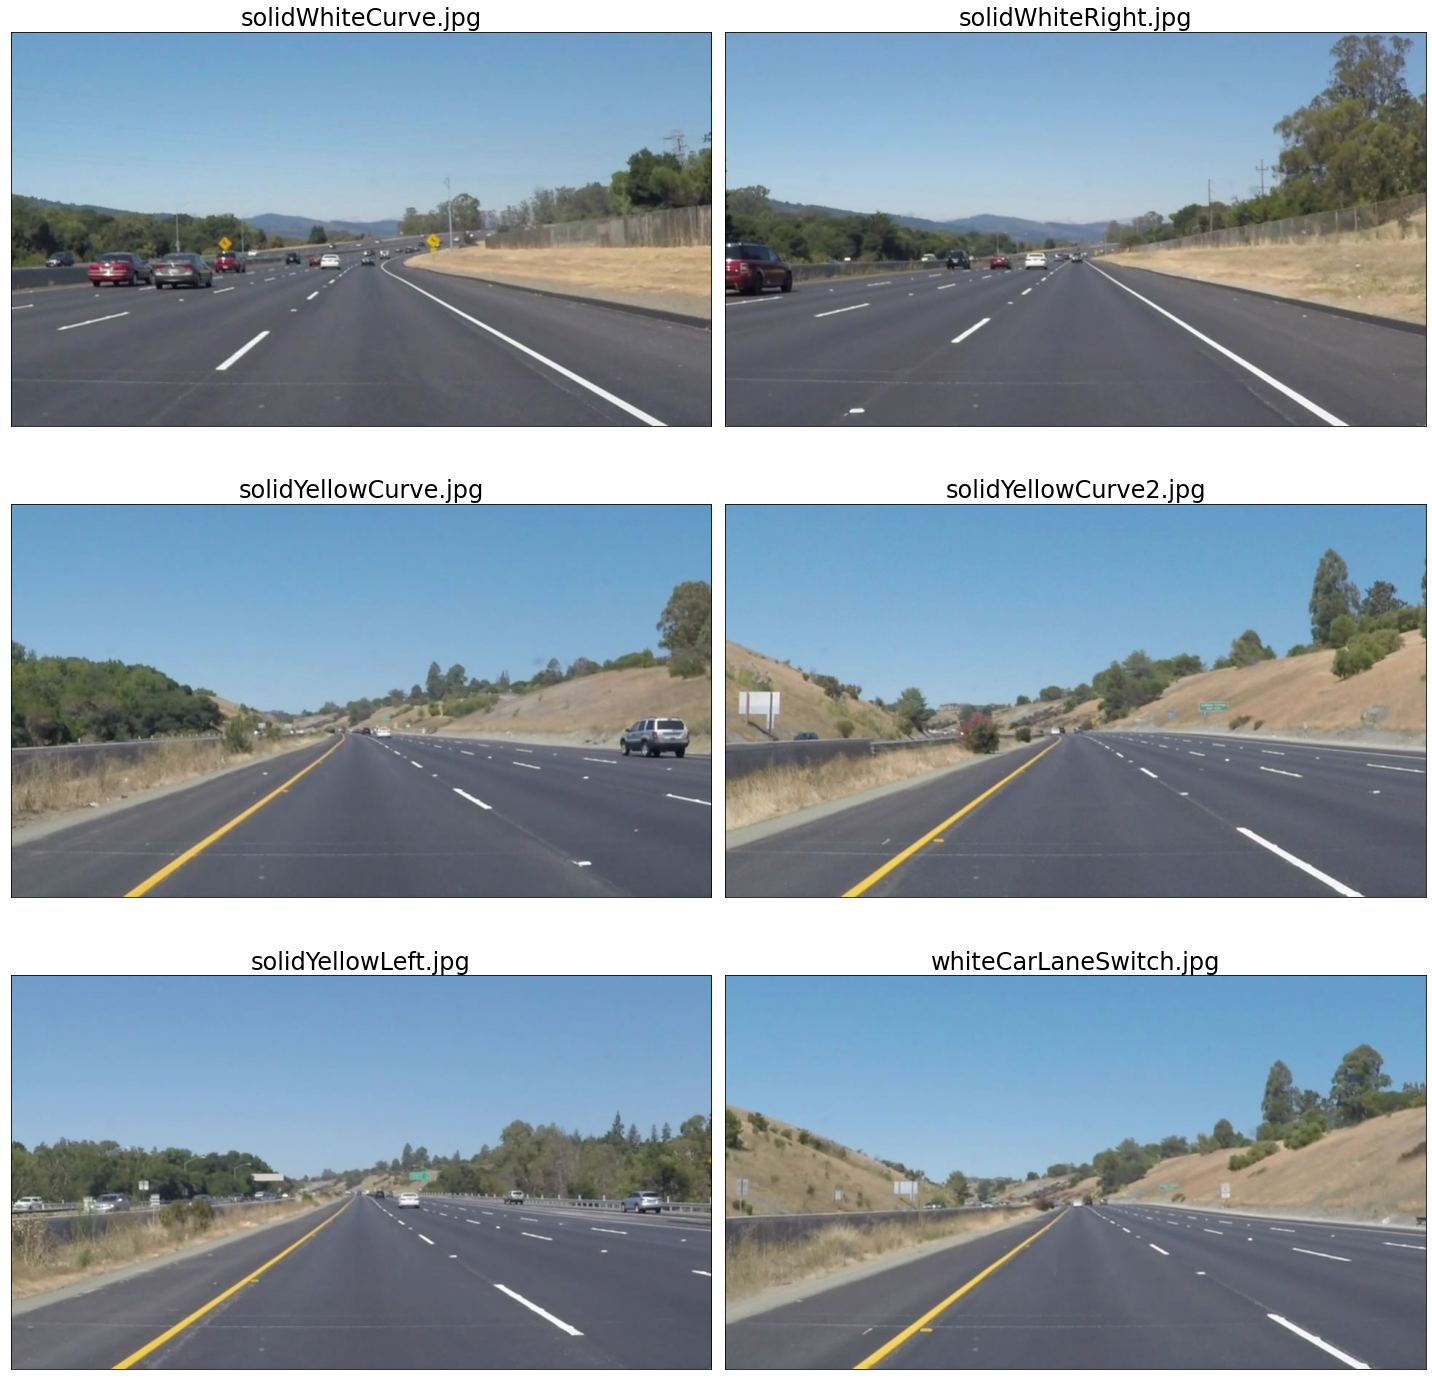

In [4]:
plot_images( image_files )

In [5]:
def process_pipeline( image_files ): 
   """Pipeline for lane finding"""
   # Check for empty list
   if not image_files: 
       print(" image_files is empty - returning") 
       return 
   # Create test_images_output directory if it doesnt exist 
   os.makedirs( 'test_images_output', exist_ok=True ) 

   for i,img in enumerate( image_files ): 
       path,filename = os.path.split( img ) 
       topdir,_ = os.path.split( path ) 

       # Create a subir in test_images_output for each test image
       subdir_name,_ = os.path.splitext( filename ) 
       subdir_path = os.path.join( topdir, 'test_images_output'+"/"+subdir_name) 
       os.makedirs( subdir_path, exist_ok=True ) 

       # Stage 1. Read an Image and apply Color Filter
       print("Processing {}".format( filename ) ) 
       image = mpimg.imread( img ) 
       filtered_image = filter_colors( image, colorspace ) 
       if colorspace == ColorSpace.RGB: 
           save_image( filtered_image, subdir_path, fname= "1_filter_rgb_"+filename) 
       elif colorspace == ColorSpace.HSV: 
           save_image( filtered_image, subdir_path, fname= "1_filter_hsv_"+filename) 
       elif colorspace == ColorSpace.HSL: 
           save_image( filtered_image, subdir_path, fname= "1_filter_hsl_"+filename) 
       else: 
           print("Unknow ColorSpace {}".format( ColorSpace ) ) 
           return 

       # Stage 2. Convert to gray scale 
       gray_image = color_to_gray( filtered_image ) 
       save_image( gray_image, subdir_path, fname= "2_gray_"+filename) 

       # Stage 3. Apply Gaussian smoothing 
       smoothed_image = gaussian_blur( gray_image, kernel_size ) 
       save_image( smoothed_image, subdir_path, fname= "3_smoothed_"+filename) 

       # Stage 4. Find edges using Canny edge detection 
       edges_image = canny_edges( smoothed_image, low_threshold, high_threshold ) 
       save_image( edges_image, subdir_path, fname= "4_edges_"+filename) 

       # Stage 5. Set ROI vertices for the edges_image 
       vertices = calculate_roi_vertices( image ) 
       roi_image = apply_roi_vertices( edges_image, vertices ) 
       save_image( roi_image, subdir_path, fname= "5_roi_"+filename) 

       # Stage 6. Apply Probablistic Hough Tranform to the ROI edge set and draw lane lines 
       roi_lines = hough_lines( roi_image, rho, theta, threshold, min_line_len, max_line_gap ) 
       lines_image = draw_lines( image, roi_lines )
       save_image( lines_image, subdir_path, fname= "6_lane_lines_"+filename) 

       # Stage 7. Apply weigthed image 
       overlay_image = weighted_img( lines_image, image ) 
       save_image( overlay_image, subdir_path, fname= "7_overlay_"+filename) 


In [6]:
process_pipeline( image_files )

Processing solidWhiteCurve.jpg
Processing solidWhiteRight.jpg
Processing solidYellowCurve.jpg
Processing solidYellowCurve2.jpg
Processing solidYellowLeft.jpg
Processing whiteCarLaneSwitch.jpg


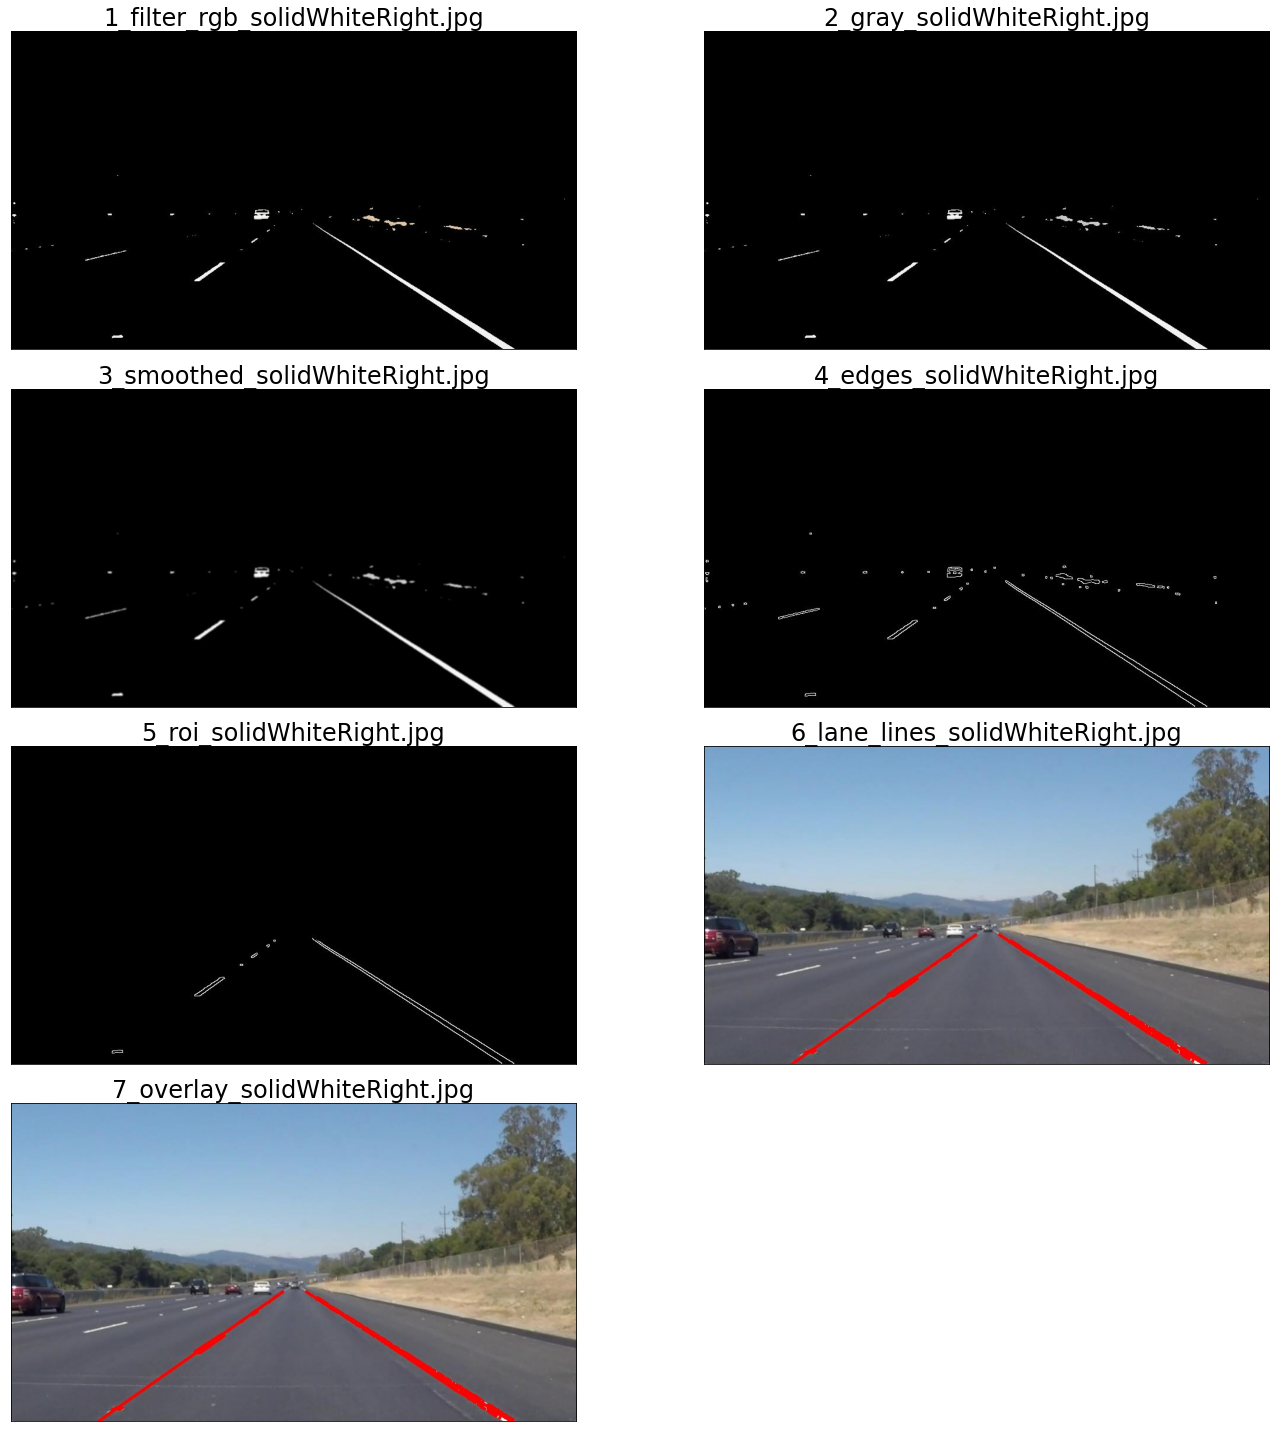

In [7]:
output_image_files = find_images( 'test_images_output/solidWhiteRight' )

plot_images( output_image_files )

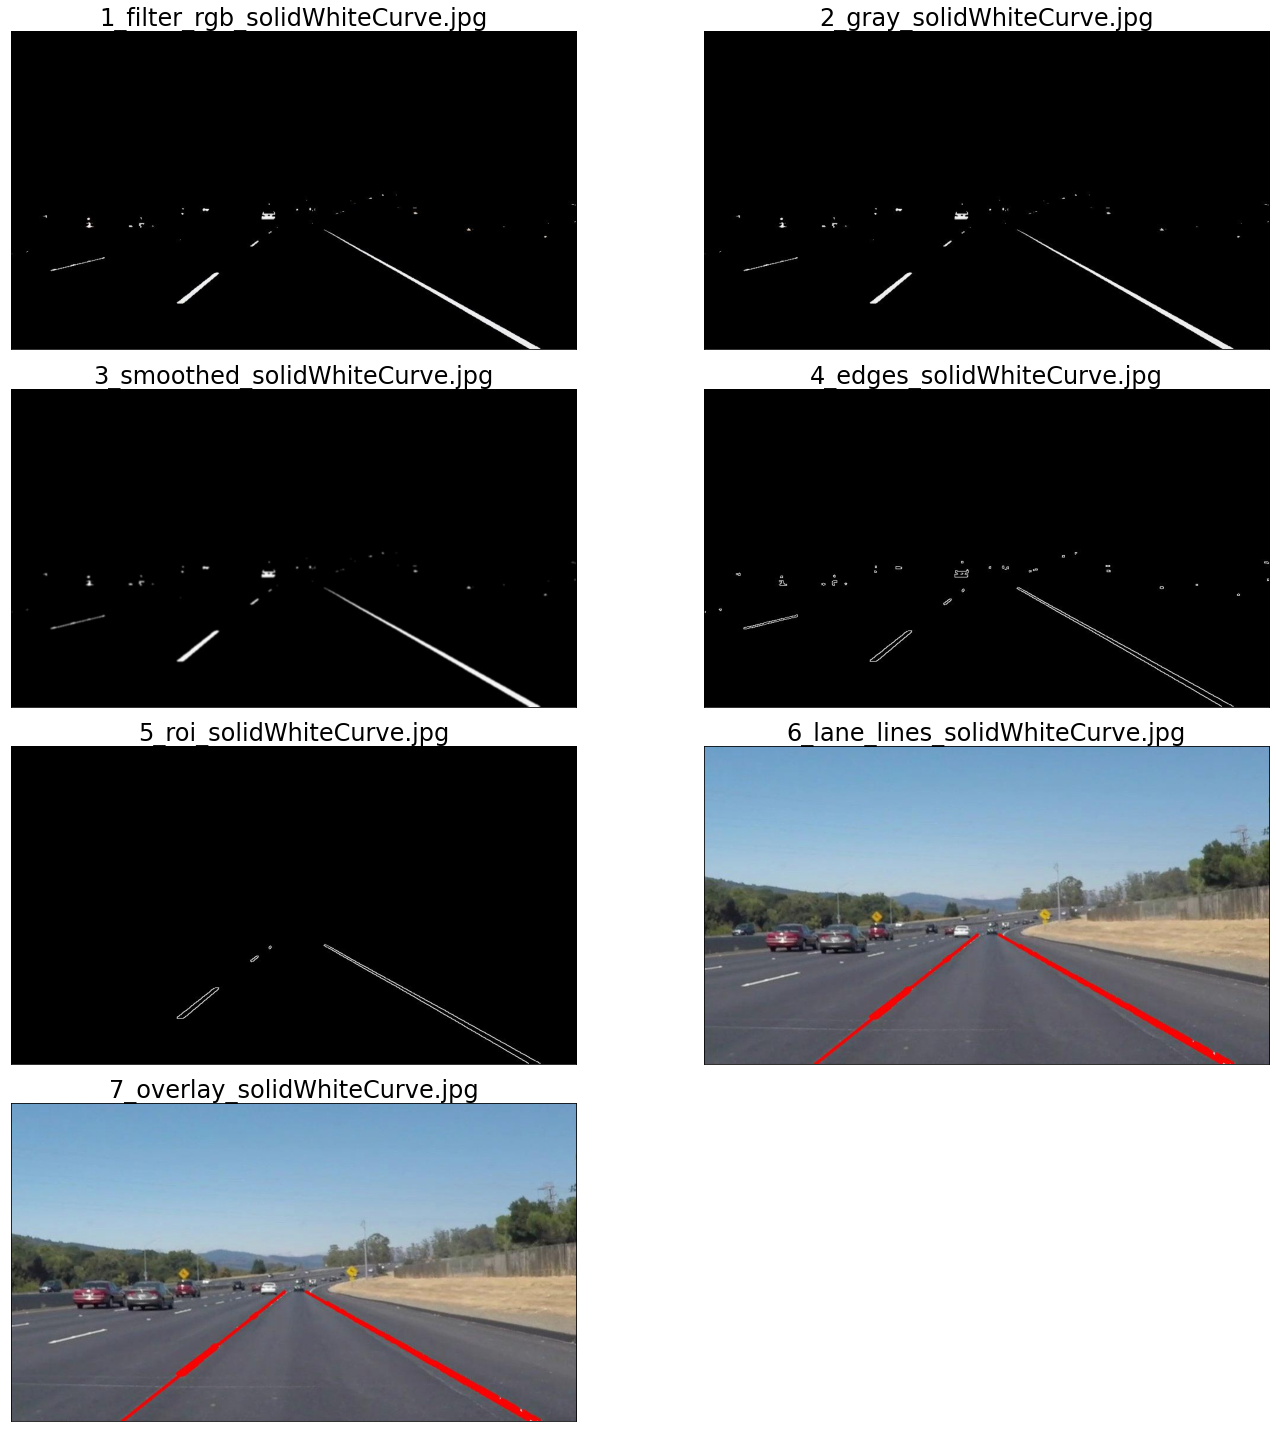

In [8]:
output_image_files = find_images( 'test_images_output/solidWhiteCurve' )

plot_images( output_image_files )

In [ ]:
output_image_files = find_images( 'test_images_output/whiteCarLaneSwitch' )

plot_images( output_image_files )